# sprint12 畳み込みニューラルネットワーク2

## 2次元の畳み込みニューラルネットワークスクラッチ

2次元に対応した畳み込みニューラルネットワーク（CNN）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


プーリング層なども作成することで、CNNの基本形を完成させます。クラスの名前はScratch2dCNNClassifierとしてください。


### データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。


今回は白黒画像ですからチャンネルは1つしかありませんが、チャンネル方向の軸は用意しておく必要があります。


(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にしてください。

## 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

→SimpleConv2d

## 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

→Scratch2dCNNClassifierの中

## 【問題3】最大プーリング層の作成

→MaxPool2D

## 【問題5】平滑化

→Flatten（問１を動かすために、先にScratch2dCNNClassifierの中で実装してしまったのでクラスは作成しましたが、呼んでいません）

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 《データセットをダウンロードするコード》 28*28
np.set_printoptions(precision=8)    # 小数点以下出力桁数
np.set_printoptions(suppress=True)    #指数表示禁止

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)

In [4]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
# 分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 1, 28, 28)
(12000, 1, 28, 28)


In [5]:
from sklearn.preprocessing import OneHotEncoder
# one-hotエンコーディング
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
y_train_onehot = enc.fit_transform(y_train[:, np.newaxis])

### 初期値クラス SimpleInitializer

In [6]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2, Fh=None, Fw=None):
        """
        重みの初期化
        Parameters
        ----------
        FC層
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        
        conv層(Out_ch、In_ch、Fil_w)
        n_nodes1 : int
          後の層のノード数
        n_nodes2 : int
          前の層のノード数
        Fil_w  :  int
           フィルタ幅
        
        Returns
        ----------
        W :
        """
        if Fh == None:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        else:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2, Fh, Fw)

        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### 初期値クラス  XavierInitializer

In [7]:
class XavierInitializer:
    def W(self, n_nodes1, n_nodes2, Fh=None, Fw=None):
        self.sigma = 1/np.sqrt(n_nodes1)
        if Fh == None:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        else:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2, Fh, Fw)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### 初期値クラス  HeInitializer

In [8]:
class HeInitializer:
    def W(self, n_nodes1, n_nodes2, Fh=None, Fw=None):
        self.sigma = np.sqrt(2/n_nodes1)
        if Fh == None:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        else:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2, Fh, Fw)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### Optimizer SGD

In [9]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        layer.w -= self.lr*layer.dW
        layer.b -= self.lr*layer.dB
        
        return layer

### Optimizer AdaGrad

In [10]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr, hw, hb):
        self.lr = lr
        self.hw = hw
        self.hb = hb
        
    def update(self, layer):
        self.hw = layer.dW**2 + self.hw
        layer.w -= self.lr * np.sqrt(self.hw) * layer.dW
        
        self.hb = layer.dB**2 + self.hb
        layer.b -= self.lr * np.sqrt(self.hb) *  layer.dB
        
        return layer

### 活性化関数 ReLU

In [11]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.Z = np.maximum(A, 0)
        return self.Z
    
    def backward(self,dZ):
        dA = np.where(self.Z > 0, dZ, 0)
        return dA

### 活性化関数 Softmax

In [12]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.Z = np.exp(A)/np.sum(np.exp(A), axis=1, keepdims=True)
        return self.Z
    
    def backward(self, ty):
        dA = self.Z - ty
        return dA

### 活性化関数 Sigmoid

In [13]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        self.Z = 1/(1+np.exp(-A)) 
        return self.Z
    
    def backward(self, dZ):
        dA = dZ * (1 - self.Z) * self.Z
        return dA

### 活性化関数 Tanh

In [14]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        
        self.Z = np.tanh(A)
        return self.Z
    
    def backward(self, dZ):
        dA = dZ * (1 - self.Z**2)    #tanh関数の微分
        return dA

### FC層

In [15]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
        
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.w = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.X = X
        A = np.dot(self.X, self.w) + self.b
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        self.dW = np.dot(self.X.T, dA)
        self.dB = np.sum(dA, axis=0)
        self.dZ = np.dot(dA, self.w.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return self.dZ

### SimpleConv2d

In [16]:
class SimpleConv2d:
    """
    Parameters
    ----------
    N : サンプル数
    In_ch : 入力チャネル数
    H : 入力画像の高さ
    W : 入力画像の幅
    Fn : フィルタ枚数=出力チャネル数
    
    Out_w : 出力サイズ
    Fh : フィルタ高さ
    Fw : フィルタ幅
    stride : ストライド
    pad : パディング
    
    n_features : 入力特徴量数
    Out_w : 出力サイズ（幅）
    
    X : 次の形のndarray, shape(N, In_ch, H, W)
    w : 次の形のndarray, shape(Fn, In_ch, Fh, Fw)
    b : 次の形のndarray, shape（Fn）
    """
    def __init__(self, In_ch, Fn, Fh, Fw, stride, pad, initializer, optimizer):
        self.stride = stride
        self.pad = pad
        self.optimizer = optimizer
        
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.w = initializer.W(Fn, In_ch, Fh, Fw) 
        self.b = initializer.B(Fn)
        
    
    def forward(self, X):
        # Xが1次元なら(1, n_features)にreshape
        self.X = X
        N, In_ch, H, W = X.shape
        Fn, In_ch, Fh, Fw = self.w.shape
        # 出力サイズの計算
        Out_h = int(1 + (H + 2*self.pad - Fh)/self.stride)
        Out_w = int(1 + (W + 2*self.pad - Fw)/self.stride)
        
        A = np.zeros((N, Fn, Out_h, Out_w))    #出力A用の入れ物の用意
        self.X_pad = np.lib.pad(X, ((0, 0), (0, 0), (self.pad, self.pad), (self.pad, self.pad)), "constant", constant_values=0)

        for n in range(N):    # サンプル数
            for i in range(Out_h):    # 出力高さ
                for j in range(Out_w):    # 出力幅
                    for m in range(Fn):    # フィルタ枚数(出力チャネル数)
                        A[n, m, i, j] = np.sum(self.X_pad[n, :, i:i+Fh, j:j+Fw]*self.w[m, :, :, :]) + self.b[m]
                        
        return A
    
    def backward(self, dA):
        N, In_ch, H, W = self.X.shape
        Fn, In_ch, Fh, Fw = self.w.shape
        N, Fn, Out_h, Out_w = dA.shape
        
        self.dX = np.zeros(self.X_pad.shape)
        self.dB = np.zeros(self.b.shape)
        self.dW = np.zeros(self.w.shape)
        
        # sumされているのでサイズが合わないため、dAを関係のあったところに渡す
        for n in range(N):    # サンプル数
            for m in range(Fn):    # フィルタ枚数(出力チャネル数)
                for i in range(Out_h):    # 出力高さ
                    for j in range(Out_w):    # 出力幅
                        self.dX[n, :, i : i+Fh, j : j+Fw] += dA[n, m, i, j]*self.w[m, :, :, :]
        
        del_rows = range(self.pad),range(H+self.pad, H+2*self.pad, 1)
        del_cols = range(self.pad),range(W+self.pad, W+2*self.pad, 1)
        
        self.dX = np.delete(self.dX, del_rows, axis=2)
        self.dX = np.delete(self.dX, del_cols, axis=3)

        for n in range(N):
            for m in range(Fn):
                for i in range(Out_h):
                    for j in range(Out_w):
                        self.dW[m, :, :, :] += dA[n, m, i, j]*self.X_pad[n, :,i:i+Fh, j:j+Fw]
                        
        
        for m in range(Fn):
            self.dB[m] = np.sum(dA[:, m, :, :])
        # 更新
        self = self.optimizer.update(self)
        return self.dX

### GetMiniBatch

In [17]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [34]:
class Flatten:
    def __init__(self, filter_list, stride, pad, H, W):
        self.filter_list = filter_list
        self.stride = stride
        self.pad = pad
        # conv最後の出力サイズの計算
        nh, nw = H, W
        for i in range(len(self.filter_list)):
            Out_h = int(1 + (nh + 2*self.pad - Fh)/self.stride)
            Out_w = int(1 + (nw + 2*self.pad - Fw)/self.stride)
            nh, nw = Out_h, Out_w

        # conv→FC reshape用 flat_Out_ch=フィルタ枚数
        self.flat_Fn, self.flat_Out_h, self.flat_Out_w = self.filter_list[-1], Out_h, Out_w
        FC_node1 = int(self.flat_Fn * self.flat_Out_h * self.flat_Out_w)
        return FC_node1
        
    def forward(self, batch):
        Z = Z.reshape(batch, self.flat_Fn * self.flat_Out_h * self.flat_Out_w)
        return Z
    
    def backward(self, batch):
        dZ = dZ.reshape(batch, self.flat_Fn, self.flat_Out_h, self.flat_Out_w)
        return dZ

### Scratch2dCNNClassifier

In [62]:
class Scratch2dCNNClassifier:
    def __init__(self, filter_list, nodes_list, lr=0.01 ,sigma=0.01, n_output=10):
        self.lr = lr     # 学習係数
        self.sigma = sigma    # 重みとバイアスの広がり具合
        self.n_output = n_output
        self.filter_list = filter_list    # フィルタ枚数のリスト
        self.nodes_list = nodes_list    # FC層数のリスト　
    
    def fit(self, X, y, Initializers, activations, Fh=3, Fw=3, stride=1, pad=0, opt="SGD", epoch=1, batch=10, Pooling=None):
        N, In_ch, H, W = X.shape
        self.loss = np.zeros(epoch)
        self.activation_list = []
        self.FC_list = []
        self.conv_list = []
        self.Pooling_list = []
        self.pad = pad
        self.stride = stride
        self.Pooling = Pooling
        
        # conv最後の出力サイズの計算
        nh, nw = H, W
        for i in range(len(self.filter_list)):
            Out_h = int(1 + (nh + 2*self.pad - Fh)/self.stride)
            Out_w = int(1 + (nw + 2*self.pad - Fw)/self.stride)
            if not self.Pooling == None:
                Out_h = Out_h//self.Pooling
                Out_w = Out_w//self.Pooling
            nh, nw = Out_h, Out_w
            
        # conv→FC reshape用 flat_Out_ch=フィルタ枚数
        self.flat_Fn, self.flat_Out_h, self.flat_Out_w = self.filter_list[-1], Out_h, Out_w
        FC_node1 = int(self.flat_Fn * self.flat_Out_h * self.flat_Out_w)
        count = 0
        # インスタンス生成---------------------------------------------------
        for i in range(len(Initializers)):
            # 初期値----------------------------------------
            if Initializers[i] == "Simple":
                initializ = SimpleInitializer(self.sigma)
            elif Initializers[i] == "Xavier":
                initializ = XavierInitializer()
            else:
                initializ = HeInitializer()
            # 最適化手法-----------------------------------
            if opt == "SGD":
                optimizer = SGD(self.lr)
            else:
                optimizer = AdaGrad(self.lr, 0, 0)
            # 畳み込み層インスタンス生成-------------------
            if i < len(self.filter_list):
                self.conv_list.append(SimpleConv2d(In_ch, self.filter_list[i], Fh, Fw, stride, pad, initializ, optimizer))
                # プーリング層インスタンス生成
                if not self.Pooling == None:
                    self.Pooling_list.append(MaxPool2D(self.Pooling))
            else:    # FC層インスタンス生成------------------
                
                if i == len(self.filter_list):
                    self.FC_list.append(FC(FC_node1, self.nodes_list[count], initializ, optimizer))    # conv→FC
                else:
                    self.FC_list.append(FC(self.FC_list[count - 1], self.nodes_list[count], initializ, optimizer))
                count += 1
                
            
            # 活性化関数インスタンス生成----------------
            if i < len(self.filter_list):
                if activations[i] == "tanh":
                    self.activation_list.append(Tanh() )
                elif activations[i] == "sigmoid":
                    self.activation_list.append(Sigmoid() )
                else:
                    self.activation_list.append(ReLU() )
            else:
                self.activation_list.append(Softmax() )
        # -----------------------------------------------------------------end
           
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X, y, batch)    # ミニバッチ生成
            for mini_X_train, mini_y_train in get_mini_batch:    # ミニバッチ学習則
                # 順伝播-------------------------------------------------------------------
                A = self.conv_list[0].forward(mini_X_train)    # 畳み込み層 1層目
                Z = self.activation_list[0].forward(A)
                if not self.Pooling == None:    # プーリング層
                    Z = self.Pooling_list[0].forward(Z)

                for j in range(1, len(self.conv_list)):    # 畳み込み層 2層目以降
                    A = self.conv_list[j].forward(Z)
                    Z = self.activation_list[j].forward(A)
                    if not self.Pooling == None:    # プーリング層
                        Z = self.Pooling_list[j].forward(Z)
                        
                # conv→FCのreshape
                Z = Z.reshape(batch, self.flat_Fn * self.flat_Out_h * self.flat_Out_w)
                
                for j in range(0, len(self.FC_list)):    # FC層 
                    A = self.FC_list[j].forward(Z)    # 出力層
                    Z = self.activation_list[len(self.conv_list)+j].forward(A)
                    
                # 逆伝播--------------------------------------------------------------------
                dZ = mini_y_train
                
                for j in reversed(range(0, len(self.FC_list))):    # FC層 
                    dA = self.activation_list[len(self.conv_list)+j].backward(dZ)
                    dZ = self.FC_list[j].backward(dA)    # 出力層
                    
                # FC→convのreshape
                dZ = dZ.reshape(batch, self.flat_Fn, self.flat_Out_h, self.flat_Out_w)
                
                for j in reversed(range(0, len(self.conv_list))):    # 中間層
                    if not self.Pooling == None:    # プーリング層
                        dZ = self.Pooling_list[j].backward(dZ)
                
                    dA = self.activation_list[j].backward(dZ)
                    dZ = self.conv_list[j].backward(dA)
                # -----------------------------------------------------------------end
            yp = self.predict(X)
            # 損失関数
            self.loss[i] = -np.sum(y * np.log(self.predict_y))/ self.predict_y.shape[1]
            
    def calc_out_shape(self, n_node1):
        # 出力サイズの計算
        return int(1 + (n_node1 + 2*self.pad - self.Fil_w)/self.stride)
    
    def predict(self,X):
        # 順伝播-------------------------------------------------------------------
        A = self.conv_list[0].forward(X)    # 畳み込み層 1層目
        Z = self.activation_list[0].forward(A)
        if not self.Pooling == None:    # プーリング層
            Z = self.Pooling_list[0].forward(Z)

        for j in range(1, len(self.conv_list)):    # 畳み込み層 2層目以降
            A = self.conv_list[j].forward(Z)
            Z = self.activation_list[j].forward(A)
            if not self.Pooling == None:    # プーリング層
                Z = self.Pooling_list[j].forward(Z)

        # conv→FCのreshape
        Z = Z.reshape(X.shape[0], self.flat_Fn * self.flat_Out_h * self.flat_Out_w)

        for j in range(0, len(self.FC_list)):    # FC層 
            A = self.FC_list[j].forward(Z)    # 出力層
            Z = self.activation_list[len(self.conv_list)+j].forward(A)
        
        self.predict_y = Z.copy()
        
        return np.argsort(Z)[:,-1]

## 【問題1】の動作確認

In [142]:
scCNN_1 = Scratch2dCNNClassifier(filter_list=[5], nodes_list=[10])

In [143]:
scCNN_1.fit(X_train[0:50], y_train_onehot[0:50], Initializers=["Xavier", "Xavier"], activations=["ReLU", "Softmax"], epoch=5)

In [144]:
scCNN_1.predict(X_train[0:50])

array([3, 1, 0, 3, 1, 8, 7, 2, 1, 2, 6, 4, 0, 0, 8, 7, 3, 7, 2, 7, 4, 0,
       1, 4, 6, 5, 1, 6, 6, 3, 3, 0, 4, 2, 5, 3, 8, 3, 5, 1, 8, 7, 8, 9,
       6, 2, 7, 0, 3, 2])

In [145]:
scCNN_1.loss

array([9.90908621, 5.5207547 , 2.04839066, 1.94649068, 0.64184545])

## 【問題3】最大プーリング層の作成

### MaxPool2D

In [28]:
class MaxPool2D:
    
    def __init__(self, P):
        self.P = P
    def forward(self, X):
        self.X = X
        N, C, H, W = X.shape
        X_pool = np.zeros([N, C, H//self.P, W//self.P])
        self.index_pool = np.zeros(X_pool.shape)
        for i in range(H//self.P):
            for j in range(W//self.P):
    #             m = np.max(X[:,:,i*P : i*P+P, j*P : j*P+P], axis=2)
    #             X_pool[:, :, i, j] = np.max(m, axis=2)
    #             index_pool_col[:, :, i, j] = np.argmax(m, axis=2)
                for k in range(C):
                    for n in range(N):
                        X_pool[n, k, i, j] = np.max(X[n,k,i*self.P : i*self.P+self.P, j*self.P : j*self.P+self.P])
                        self.index_pool[n, k, i, j] = np.argmax(X[n,k,i*self.P : i*self.P+self.P, j*self.P : j*self.P+self.P])

        return X_pool
    
    def backward(self, Z):
        N, C, H, W = Z.shape
        reX = np.zeros(self.X.shape)
        for i in range(H):
            for j in range(W):
                for k in range(C):
                    for n in range(N):
                        arr = np.zeros(4)
                        arr[int(self.index_pool[n, k, i, j])] = Z[n, k, i, j]
                        arr = arr.reshape(reX[n, k, i*self.P: i*self.P+self.P, j*self.P:j*self.P+self.P].shape)
                        reX[n, k, i*self.P: i*self.P+self.P, j*self.P:j*self.P+self.P] = arr
        return reX
        

In [30]:
test_data = np.random.randint(0,10, (2, 1, 8, 8))
test_data

array([[[[3, 7, 7, 4, 2, 0, 5, 6],
         [9, 2, 8, 2, 1, 5, 7, 2],
         [2, 5, 0, 8, 0, 0, 8, 9],
         [1, 3, 8, 2, 5, 2, 2, 9],
         [2, 9, 5, 0, 1, 1, 1, 2],
         [3, 7, 3, 5, 7, 4, 9, 3],
         [8, 2, 6, 0, 9, 0, 6, 0],
         [2, 4, 5, 8, 1, 9, 9, 8]]],


       [[[0, 5, 2, 6, 1, 1, 2, 7],
         [9, 7, 2, 7, 4, 6, 0, 3],
         [9, 0, 2, 8, 5, 7, 9, 0],
         [1, 9, 4, 5, 2, 3, 9, 0],
         [6, 3, 3, 1, 4, 1, 0, 8],
         [4, 7, 7, 9, 1, 0, 1, 0],
         [3, 7, 3, 2, 3, 4, 3, 1],
         [7, 0, 1, 2, 9, 8, 3, 2]]]])

In [31]:
m2d = MaxPool2D(P=2)
Z = m2d.forward(test_data)
Z

array([[[[9., 8., 5., 7.],
         [5., 8., 5., 9.],
         [9., 5., 7., 9.],
         [8., 8., 9., 9.]]],


       [[[9., 7., 6., 7.],
         [9., 8., 7., 9.],
         [7., 9., 4., 8.],
         [7., 3., 9., 3.]]]])

In [33]:
m2d.backward(Z)

array([[[[0., 0., 0., 0., 0., 0., 0., 0.],
         [9., 0., 8., 0., 0., 5., 7., 0.],
         [0., 5., 0., 8., 0., 0., 0., 9.],
         [0., 0., 0., 0., 5., 0., 0., 0.],
         [0., 9., 5., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 7., 0., 9., 0.],
         [8., 0., 0., 0., 9., 0., 0., 0.],
         [0., 0., 0., 8., 0., 0., 9., 0.]]],


       [[[0., 0., 0., 0., 0., 0., 0., 7.],
         [9., 0., 0., 7., 0., 6., 0., 0.],
         [9., 0., 0., 8., 0., 7., 9., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 4., 0., 0., 8.],
         [0., 7., 0., 9., 0., 0., 0., 0.],
         [0., 7., 3., 0., 0., 0., 3., 0.],
         [0., 0., 0., 0., 9., 0., 0., 0.]]]])

## 【問題6】学習と推定

In [63]:
scCNN_2 = Scratch2dCNNClassifier(filter_list=[5], nodes_list=[10])

In [64]:
# 処理に時間がかかるので、データを減らして学習
scCNN_2.fit(X_train[0:5000], y_train_onehot[0:5000], Initializers=["Xavier", "Xavier"],
            activations=["ReLU", "Softmax"], epoch=10)

In [66]:
yp = scCNN_2.predict(X_test)

In [67]:
# 正解率
from sklearn.metrics import accuracy_score
accuracy_score(y_test, yp)

0.9488

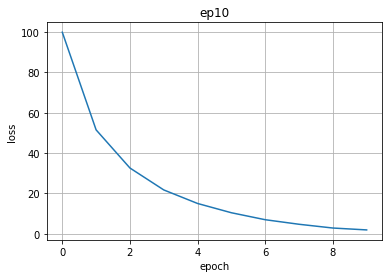

In [68]:
import matplotlib.pyplot as plt
# 折れ線グラフを出力
trans_x = np.array(range(len(scCNN_2.loss)))
plt.title("ep10")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(trans_x, scCNN_2.loss)
plt.grid(True)
plt.show()

pooling層ありで学習

In [69]:
scCNN_3 = Scratch2dCNNClassifier(filter_list=[5], nodes_list=[10])

In [70]:
scCNN_3.fit(X_train[0:100], y_train_onehot[0:100], Initializers=["Xavier", "Xavier"],
            activations=["ReLU", "Softmax"], epoch=10,Pooling=2)


In [71]:
scCNN_3.loss

array([20.43231138, 13.5282083 , 10.47565625,  6.415138  ,  3.6902721 ,
        2.45279494,  1.51043062,  0.77628572,  0.49368225,  0.38128946])

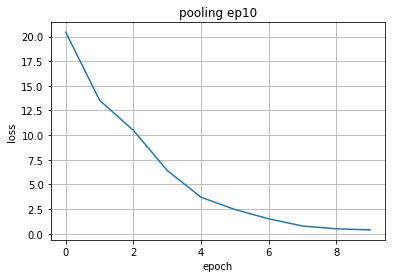

In [72]:
# 折れ線グラフを出力
trans_x = np.array(range(len(scCNN_3.loss)))
plt.title("pooling ep10")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(trans_x, scCNN_3.loss)
plt.grid(True)
plt.show()

## 【問題8】（アドバンス課題）有名な画像認識モデルの調査

- AlexNet (2012)　https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
- ZFNet (2013)　https://arxiv.org/pdf/1311.2901.pdf
- GoogLeNet (2014) https://arxiv.org/pdf/1409.4842.pdf
- VGGNet (2014) https://arxiv.org/pdf/1409.1556.pdf
- ResNet (2015) https://arxiv.org/pdf/1512.03385.pdf
- SENet (2017) https://arxiv.org/pdf/1511.00561.pdf

## 【問題9】出力サイズとパラメータ数の計算

以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


### 1.
- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

In [74]:
H, W, S, P = 144, 144, 1, 0
Fh, Fw = 3, 3
# 出力サイズの計算
Out_h = int(1 + (H + 2*P - Fh)/S)
Out_w = int(1 + (W + 2*P - Fw)/S)
print("出力高さ", Out_h)
print("出力幅", Out_w)

出力高さ 142
出力幅 142


【回答】出力サイズ：142x142x6  パラメータ数：168(w=6x3x3x3　b=6)

### 2.
- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

In [76]:
H, W, S, P = 60, 60, 1, 0
Fh, Fw = 3, 3
# 出力サイズの計算
Out_h = int(1 + (H + 2*P - Fh)/S)
Out_w = int(1 + (W + 2*P - Fw)/S)
print("出力高さ", Out_h)
print("出力幅", Out_w)

出力高さ 58
出力幅 58


【回答】出力サイズ：58x58x48  パラメータ数：10416(w=48x24x3x3　b=48)

### 3.
- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

In [79]:
H, W, S, P = 20, 20, 1, 0
Fh, Fw = 3, 3
# 出力サイズの計算
Out_h = int(1 + (H + 2*P - Fh)//S)
Out_w = int(1 + (W + 2*P - Fw)//S)
print("出力高さ", Out_h)
print("出力幅", Out_w)

出力高さ 18
出力幅 18


【回答】出力サイズ：18x18x20  パラメータ数：1820(w=20x10x3x3　b=20)

## 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。


- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果

【回答】<br>
フィルタサイズは奇数かつ小さいサイズで精度が出やすい。奇数の理由は中心を取るため。<br>
1x1フィルタは畳み込み層の間に挟み、出力チャンネルを減らすことで、パラメータ数の削減に繋がるため<br>

## m2col
im2colの理解：チャンネル1、バッチサイズ1（画像枚数1）、パディングなし、ストライド1の時

In [81]:
def im2col_test(image, flt_h, flt_w, out_h, out_w):
    img_h, img_w = image.shape
    
    cols = np.zeros((flt_h*flt_w, out_h*out_w))
    
    for h in range(out_h):
        h_lim = h + flt_h
        for w in range(out_w):
            w_lim = w + flt_w
            cols[:, h*out_w + w] = img[h: h_lim, w:w_lim].reshape(-1)    #切り取る範囲を指定
    print("cols", cols)
    return cols

In [82]:
img = np.array([[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 10, 11, 12],
                [13, 14, 15, 16]])
cols = im2col_test(img, 2, 2, 3, 3)
print(cols)

cols [[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]
[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]


フィルタと計算する範囲が列に並んだ
次に、for文で回す回数を少なくする

In [83]:
def im2col_test2(image, flt_h, flt_w, out_h, out_w):
    img_h, img_w = image.shape
    
    cols = np.zeros((flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + out_h
        for w in range(flt_w):
            w_lim = w + out_w
            cols[h, w, :, :] = img[h: h_lim, w:w_lim]    #切り取る範囲を指定
    print("cols", cols)
    cols = cols.reshape(flt_h*flt_w, out_h*out_w)
    return cols

In [84]:
img = np.array([[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 10, 11, 12],
                [13, 14, 15, 16]])
cols = im2col_test2(img, 2, 2, 3, 3)
print(cols)

cols [[[[ 1.  2.  3.]
   [ 5.  6.  7.]
   [ 9. 10. 11.]]

  [[ 2.  3.  4.]
   [ 6.  7.  8.]
   [10. 11. 12.]]]


 [[[ 5.  6.  7.]
   [ 9. 10. 11.]
   [13. 14. 15.]]

  [[ 6.  7.  8.]
   [10. 11. 12.]
   [14. 15. 16.]]]]
[[ 1.  2.  3.  5.  6.  7.  9. 10. 11.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16.]]


フィルタサイズで回すため、ループ回数を減らすことができた。<br>
次に、バッチサイズとチャンネル数に対応させる

In [85]:
def im2col_bt_ch(images, flt_h, flt_w, out_h, out_w):
    n_bt, n_ch, img_h, img_w = images.shape
    
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + out_h
        for w in range(flt_w):
            w_lim = w + out_w
            cols[:, :, h, w, :, :] = images[:, :, h:h_lim, w:w_lim]
    print("cols", cols)      
    print("---------")
    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    
    return cols

In [86]:
img = np.array([[[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 10, 11, 12],
                [13, 14, 15, 16]],
                [[31, 32, 33, 34],
                [35, 36, 37, 38],
                [39, 40, 41, 42],
                [43, 44, 45, 46]]])
img = img.reshape(2, 1, 4, 4)
cols = im2col_bt_ch(img, 2, 2, 3, 3)
print(cols)

cols [[[[[[ 1.  2.  3.]
     [ 5.  6.  7.]
     [ 9. 10. 11.]]

    [[ 2.  3.  4.]
     [ 6.  7.  8.]
     [10. 11. 12.]]]


   [[[ 5.  6.  7.]
     [ 9. 10. 11.]
     [13. 14. 15.]]

    [[ 6.  7.  8.]
     [10. 11. 12.]
     [14. 15. 16.]]]]]




 [[[[[31. 32. 33.]
     [35. 36. 37.]
     [39. 40. 41.]]

    [[32. 33. 34.]
     [36. 37. 38.]
     [40. 41. 42.]]]


   [[[35. 36. 37.]
     [39. 40. 41.]
     [43. 44. 45.]]

    [[36. 37. 38.]
     [40. 41. 42.]
     [44. 45. 46.]]]]]]
---------
[[ 1.  2.  3.  5.  6.  7.  9. 10. 11. 31. 32. 33. 35. 36. 37. 39. 40. 41.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12. 32. 33. 34. 36. 37. 38. 40. 41. 42.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15. 35. 36. 37. 39. 40. 41. 43. 44. 45.]
 [ 6.  7.  8. 10. 11. 12. 14. 15. 16. 36. 37. 38. 40. 41. 42. 44. 45. 46.]]


ストライドとパディングにも対応させる

In [87]:
def im2col_pad_st(images, flt_h, flt_w, out_h, out_w, stride, pad):
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0, 0), (0, 0), (pad, pad), (pad, pad)],"constant")
    
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]
    print("cols.shape", cols.shape)
    print("cols", cols)      
    print("---------")
    print("cols transposeしなかったら\n", cols.reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w))      
    print("---------")
    #print("cols.transpose(1, 2, 3, 0, 4, 5)", cols.transpose(1, 2, 3, 0, 4, 5))
    print("---------")
    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

In [88]:
img = np.array([[[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 10, 11, 12],
                [13, 14, 15, 16]],
                [[31, 32, 33, 34],
                [35, 36, 37, 38],
                [39, 40, 41, 42],
                [43, 44, 45, 46]]])
# チャンネル追加 B,Ch, Ih, Iw
img = img.reshape(2, 1, 4, 4)
# 入力画像、Fh, Fw, Oh, Ow, S, P
cols = im2col_pad_st(img, 2, 2, 3, 3, 1, 0)
print(cols)

cols.shape (2, 1, 2, 2, 3, 3)
cols [[[[[[ 1.  2.  3.]
     [ 5.  6.  7.]
     [ 9. 10. 11.]]

    [[ 2.  3.  4.]
     [ 6.  7.  8.]
     [10. 11. 12.]]]


   [[[ 5.  6.  7.]
     [ 9. 10. 11.]
     [13. 14. 15.]]

    [[ 6.  7.  8.]
     [10. 11. 12.]
     [14. 15. 16.]]]]]




 [[[[[31. 32. 33.]
     [35. 36. 37.]
     [39. 40. 41.]]

    [[32. 33. 34.]
     [36. 37. 38.]
     [40. 41. 42.]]]


   [[[35. 36. 37.]
     [39. 40. 41.]
     [43. 44. 45.]]

    [[36. 37. 38.]
     [40. 41. 42.]
     [44. 45. 46.]]]]]]
---------
cols transposeしなかったら
 [[ 1.  2.  3.  5.  6.  7.  9. 10. 11.  2.  3.  4.  6.  7.  8. 10. 11. 12.]
 [ 5.  6.  7.  9. 10. 11. 13. 14. 15.  6.  7.  8. 10. 11. 12. 14. 15. 16.]
 [31. 32. 33. 35. 36. 37. 39. 40. 41. 32. 33. 34. 36. 37. 38. 40. 41. 42.]
 [35. 36. 37. 39. 40. 41. 43. 44. 45. 36. 37. 38. 40. 41. 42. 44. 45. 46.]]
---------
---------
[[ 1.  2.  3.  5.  6.  7.  9. 10. 11. 31. 32. 33. 35. 36. 37. 39. 40. 41.]
 [ 2.  3.  4.  6.  7.  8. 10. 11. 12. 32. 33. 34. 36

In [90]:
def col2im_test(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w).transpose(3, 0, 1, 2, 4, 5)
    
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]
    return images[:, :, pad:img_h+pad, pad:img_w+pad]

In [91]:
cols

array([[ 1.,  2.,  3.,  5.,  6.,  7.,  9., 10., 11., 31., 32., 33., 35.,
        36., 37., 39., 40., 41.],
       [ 2.,  3.,  4.,  6.,  7.,  8., 10., 11., 12., 32., 33., 34., 36.,
        37., 38., 40., 41., 42.],
       [ 5.,  6.,  7.,  9., 10., 11., 13., 14., 15., 35., 36., 37., 39.,
        40., 41., 43., 44., 45.],
       [ 6.,  7.,  8., 10., 11., 12., 14., 15., 16., 36., 37., 38., 40.,
        41., 42., 44., 45., 46.]])

In [92]:
# B, Ch, Ih, Iw
img_shape = (2, 1, 4, 4)
# cols, imageshape, Fh, Fw, Oh, Ow,stride, pad
col2im_test(cols, img_shape, 2, 2, 3, 3, 1, 0)

array([[[[  1.,   4.,   6.,   4.],
         [ 10.,  24.,  28.,  16.],
         [ 18.,  40.,  44.,  24.],
         [ 13.,  28.,  30.,  16.]]],


       [[[ 31.,  64.,  66.,  34.],
         [ 70., 144., 148.,  76.],
         [ 78., 160., 164.,  84.],
         [ 43.,  88.,  90.,  46.]]]])

重なる部分は加算されていくので正しい結果となった

## np.padの理解

In [89]:
pad=2
print(np.pad(img, [(0, 0), (0, 0), (pad, pad), (pad, pad)],"constant").shape)
np.pad(img, [(0, 0), (0, 0), (pad, pad), (pad, pad)],"constant")

(2, 1, 8, 8)


array([[[[ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  1,  2,  3,  4,  0,  0],
         [ 0,  0,  5,  6,  7,  8,  0,  0],
         [ 0,  0,  9, 10, 11, 12,  0,  0],
         [ 0,  0, 13, 14, 15, 16,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0]]],


       [[[ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0, 31, 32, 33, 34,  0,  0],
         [ 0,  0, 35, 36, 37, 38,  0,  0],
         [ 0,  0, 39, 40, 41, 42,  0,  0],
         [ 0,  0, 43, 44, 45, 46,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0]]]])